In [1]:
!nvidia-smi

Sun May 31 13:25:52 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
!pip --quiet install transformers
!pip --quiet install tokenizers

     |████████████████████████████████| 665kB 4.5MB/s 
     |████████████████████████████████| 1.1MB 13.2MB/s 
     |████████████████████████████████| 890kB 23.2MB/s 
     |████████████████████████████████| 3.8MB 42.4MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -r '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Scripts/.' .

In [0]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/'
MODEL_BASE_PATH = COLAB_BASE_PATH + 'Models/Files/217-roBERTa_base/'

import os
os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [6]:
import json, warnings, shutil
from scripts_step_lr_schedulers import *
from tweet_utility_scripts import *
from tweet_utility_preprocess_roberta_scripts_aux import *
from transformers import TFRobertaModel, RobertaConfig
from tokenizers import ByteLevelBPETokenizer
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses, layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")
pd.set_option('max_colwidth', 120)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load data

In [0]:
# Unzip files
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_64_clean/fold_1.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_64_clean/fold_2.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_64_clean/fold_3.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_64_clean/fold_4.tar.gz'
!tar -xf '/content/drive/My Drive/Colab Notebooks/Tweet Sentiment Extraction/Data/complete_64_clean/fold_5.tar.gz'

In [8]:
database_base_path = COLAB_BASE_PATH + 'Data/complete_64_clean/'
k_fold = pd.read_csv(database_base_path + '5-fold.csv')
print(f'Training samples: {len(k_fold)}')
display(k_fold.head())

Training samples: 26882


,textID,text,selected_text,sentiment,jaccard,text_len,text_wordCnt,text_tokenCnt,selected_text_len,selected_text_wordCnt,selected_text_tokenCnt,fold_1,fold_2,fold_3,fold_4,fold_5,imputed
0,cb774db0d1,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,1.000000,35,7,10,35,7,10,train,validation,train,train,train,False
1,549e992a42,sooo sad i will miss you here in san diego!!!,sooo sad,negative,0.200000,45,10,13,8,2,3,validation,train,train,train,train,False
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,25,5,6,11,2,2,train,train,train,validation,train,False
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,30,5,6,14,3,3,train,train,train,validation,train,False
4,358bd9e861,"sons of ****, why couldn`t they put them on the releases we already bought","sons of ****,",negative,0.214286,74,14,17,13,3,4,train,train,train,validation,train,False


# Model parameters

In [0]:
vocab_path = COLAB_BASE_PATH + 'qa-transformers/roberta/roberta-base-vocab.json'
merges_path = COLAB_BASE_PATH + 'qa-transformers/roberta/roberta-base-merges.txt'
base_path = COLAB_BASE_PATH + 'qa-transformers/roberta/'

config = {
  "MAX_LEN": 64,
  "BATCH_SIZE": 32,
  "EPOCHS": 7,
  "LEARNING_RATE": 3e-5,
  "ES_PATIENCE": 2,
  "N_FOLDS": 5,
  "question_size": 4,
  "base_model_path": base_path + 'roberta-base-tf_model.h5',
  "config_path": base_path + 'roberta-base-config.json'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)

# Tokenizer

In [0]:
tokenizer = ByteLevelBPETokenizer(vocab_file=vocab_path, merges_file=merges_path, 
                                  lowercase=True, add_prefix_space=True)

## Learning rate schedule

Learning rate schedule: 1e-07 to 3e-05 to 1e-06


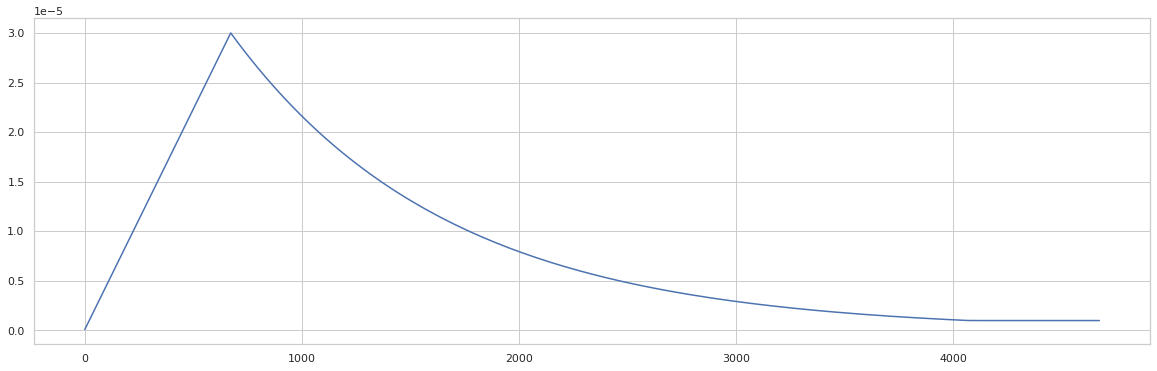

In [11]:
lr_min = 1e-6
lr_start = 1e-7
lr_max = config['LEARNING_RATE']
train_size = len(k_fold[k_fold['fold_1'] == 'train'])
step_size = train_size // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * step_size
warmup_steps = step_size * 1
decay = .999

rng = [i for i in range(0, total_steps, config['BATCH_SIZE'])]
y = [exponential_schedule_with_warmup(tf.cast(x, tf.float32), warmup_steps=warmup_steps, lr_start=lr_start, 
                                      lr_max=lr_max, lr_min=lr_min, decay=decay) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [0]:
module_config = RobertaConfig.from_pretrained(config['config_path'], output_hidden_states=True)

def model_fn(MAX_LEN):
    input_ids = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = layers.Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    
    base_model = TFRobertaModel.from_pretrained(config['base_model_path'], config=module_config, name="base_model")
    _, _, hidden_states = base_model({'input_ids': input_ids, 'attention_mask': attention_mask})
    
    h10 = hidden_states[-3]
    h11 = hidden_states[-2]

    x_mask = layers.Dropout(.1)(h10)    
    mask_logits = layers.Dense(1, name="mask_logit", use_bias=False)(x_mask)
    mask_logits = layers.Flatten()(mask_logits)
    
    x = layers.Dropout(.1)(h11)
    
    start_logits = layers.Dense(1, name="start_logit", use_bias=False)(x)
    start_logits = layers.Flatten()(start_logits)

    end_logits = layers.Dense(1, name="end_logit", use_bias=False)(x)
    end_logits = layers.Flatten()(end_logits)
    

    mask_probs = layers.Activation('sigmoid', name='y_mask')(mask_logits)
    start_probs = layers.Activation('softmax', name='y_start')(start_logits)
    end_probs = layers.Activation('softmax', name='y_end')(end_logits)

    model = Model(inputs=[input_ids, attention_mask], outputs=[start_probs, end_probs, mask_probs])
    
    return model

# Train

In [0]:
def get_training_dataset(x_train, y_train, batch_size, buffer_size, seed=0):
    dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': x_train[0], 'attention_mask': x_train[1]}, 
                                                  {'y_start': y_train[0], 'y_end': y_train[1], 'y_mask': y_train[2]}))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048, seed=seed)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_validation_dataset(x_valid, y_valid, batch_size, buffer_size, repeated=False, seed=0):
    dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': x_valid[0], 'attention_mask': x_valid[1]}, 
                                                  {'y_start': y_valid[0], 'y_end': y_valid[1], 'y_mask': y_valid[2]}))
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048, seed=seed)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.cache()
    dataset = dataset.prefetch(buffer_size)
    return dataset

In [0]:
AUTO = tf.data.experimental.AUTOTUNE
history_list = []

for n_fold in range(config['N_FOLDS']):
    n_fold +=1
    print('\nFOLD: %d' % (n_fold))

    # Load data
    base_data_path = 'fold_%d/' % (n_fold)
    x_train = np.load(base_data_path + 'x_train.npy')
    y_train = np.load(base_data_path + 'y_train.npy')
    y_train_mask = np.load(base_data_path + 'y_train_mask.npy')
    x_valid = np.load(base_data_path + 'x_valid.npy')
    y_valid = np.load(base_data_path + 'y_valid.npy')
    y_valid_mask = np.load(base_data_path + 'y_valid_mask.npy')
    
    step_size = x_train.shape[1] // config['BATCH_SIZE']

    # Train model
    model_path = 'model_fold_%d.h5' % (n_fold)
    model = model_fn(config['MAX_LEN'])
    
    es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                       restore_best_weights=True, verbose=1)
    checkpoint = ModelCheckpoint((MODEL_BASE_PATH + model_path), monitor='val_loss', mode='min', 
                                 save_best_only=True, save_weights_only=True)
    
    optimizer = optimizers.Adam(learning_rate=lambda: exponential_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                                                       warmup_steps=1, lr_start=lr_start, 
                                                                                       lr_max=lr_max, lr_min=lr_min, decay=decay))
    model.compile(optimizer, loss={'y_start': losses.CategoricalCrossentropy(label_smoothing=0.2),
                                   'y_end': losses.CategoricalCrossentropy(label_smoothing=0.2),
                                   'y_mask': losses.BinaryCrossentropy(label_smoothing=0.2)})
    
    history = model.fit(get_training_dataset(x_train, (*y_train, y_train_mask), config['BATCH_SIZE'], AUTO, seed=SEED),
                        validation_data=(get_validation_dataset(x_valid, (*y_valid, y_valid_mask), config['BATCH_SIZE'], AUTO, repeated=False, seed=SEED)),
                        epochs=config['EPOCHS'], 
                        steps_per_epoch=step_size,
                        callbacks=[checkpoint, es],
                        verbose=2).history
    
    history_list.append(history)
    
    # Make predictions
    # model.load_weights(MODEL_BASE_PATH + model_path)
    predict_eval_df(k_fold, model, x_train, x_valid, get_test_dataset, decode, n_fold, tokenizer, config, config['question_size'])


FOLD: 1
Epoch 1/7
672/672 - 163s - loss: 4.6121 - y_start_loss: 2.1020 - y_end_loss: 2.0996 - y_mask_loss: 0.4105 - val_loss: 4.1976 - val_y_start_loss: 1.9335 - val_y_end_loss: 1.8896 - val_y_mask_loss: 0.3746
Epoch 2/7
672/672 - 162s - loss: 4.1969 - y_start_loss: 1.9253 - y_end_loss: 1.8890 - y_mask_loss: 0.3827 - val_loss: 4.1645 - val_y_start_loss: 1.9263 - val_y_end_loss: 1.8657 - val_y_mask_loss: 0.3724
Epoch 3/7
672/672 - 162s - loss: 4.0978 - y_start_loss: 1.8811 - y_end_loss: 1.8373 - y_mask_loss: 0.3794 - val_loss: 4.1552 - val_y_start_loss: 1.9208 - val_y_end_loss: 1.8622 - val_y_mask_loss: 0.3722
Epoch 4/7
672/672 - 158s - loss: 4.0514 - y_start_loss: 1.8593 - y_end_loss: 1.8145 - y_mask_loss: 0.3776 - val_loss: 4.1552 - val_y_start_loss: 1.9241 - val_y_end_loss: 1.8594 - val_y_mask_loss: 0.3717
Epoch 5/7
Restoring model weights from the end of the best epoch.
672/672 - 158s - loss: 4.0123 - y_start_loss: 1.8399 - y_end_loss: 1.7961 - y_mask_loss: 0.3764 - val_loss: 4.160


FOLD: 4
Epoch 1/7
672/672 - 170s - loss: 4.6177 - y_start_loss: 2.1183 - y_end_loss: 2.0980 - y_mask_loss: 0.4014 - val_loss: 4.1825 - val_y_start_loss: 1.9256 - val_y_end_loss: 1.8842 - val_y_mask_loss: 0.3727
Epoch 2/7
672/672 - 161s - loss: 4.1833 - y_start_loss: 1.9289 - y_end_loss: 1.8772 - y_mask_loss: 0.3771 - val_loss: 4.1346 - val_y_start_loss: 1.9031 - val_y_end_loss: 1.8608 - val_y_mask_loss: 0.3707
Epoch 3/7
672/672 - 157s - loss: 4.0841 - y_start_loss: 1.8786 - y_end_loss: 1.8312 - y_mask_loss: 0.3743 - val_loss: 4.1389 - val_y_start_loss: 1.9076 - val_y_end_loss: 1.8613 - val_y_mask_loss: 0.3701
Epoch 4/7
672/672 - 161s - loss: 4.0336 - y_start_loss: 1.8584 - y_end_loss: 1.8022 - y_mask_loss: 0.3730 - val_loss: 4.1319 - val_y_start_loss: 1.9003 - val_y_end_loss: 1.8618 - val_y_mask_loss: 0.3698
Epoch 5/7
672/672 - 157s - loss: 4.0000 - y_start_loss: 1.8383 - y_end_loss: 1.7896 - y_mask_loss: 0.3721 - val_loss: 4.1426 - val_y_start_loss: 1.9057 - val_y_end_loss: 1.8673 - 

# Model loss graph

Fold: 1


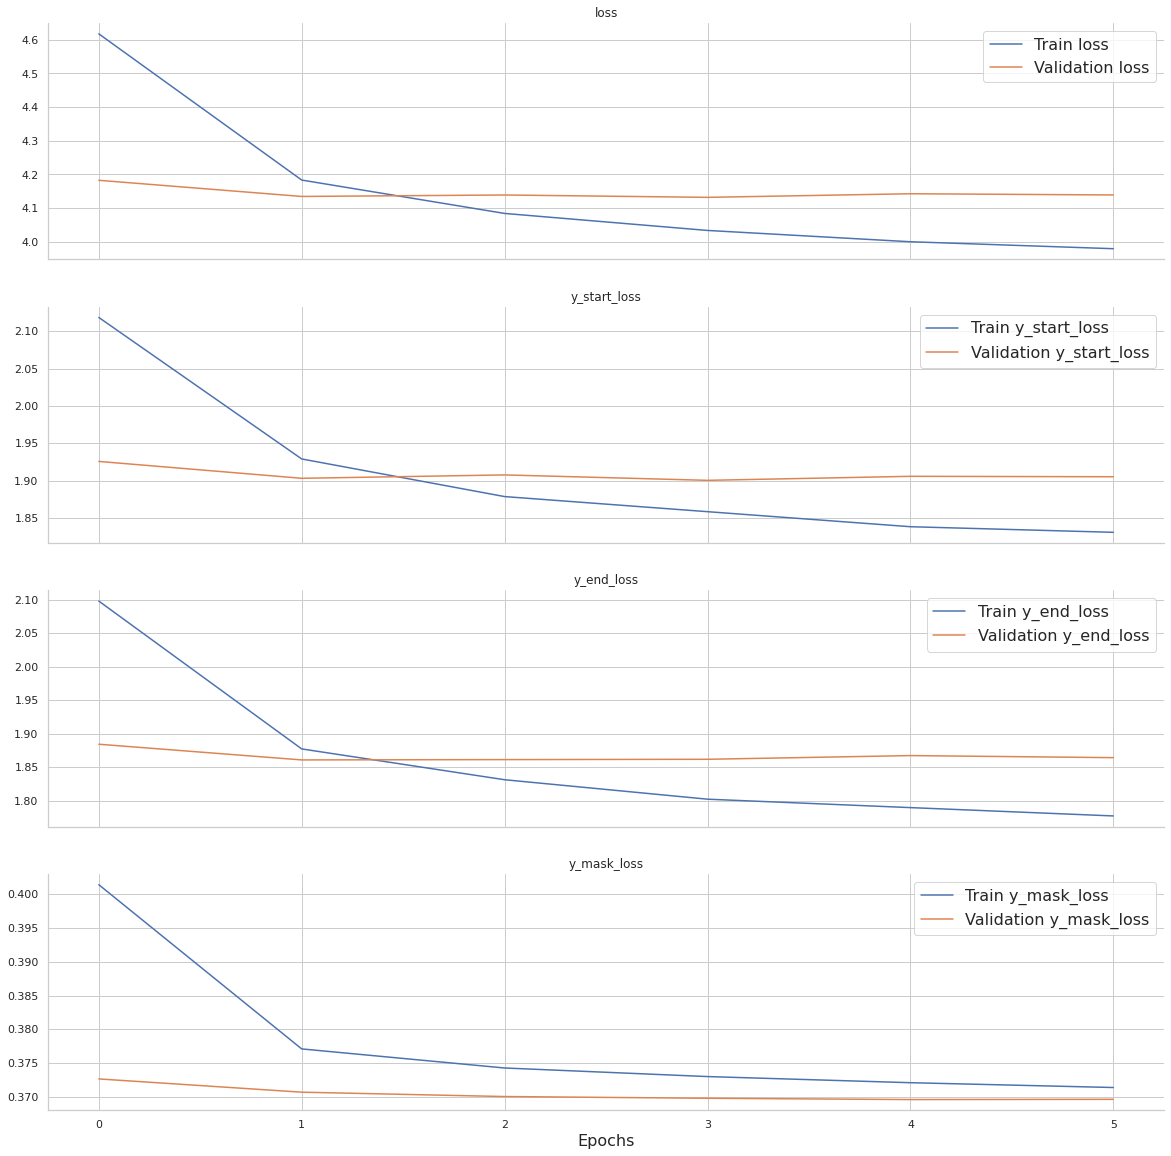

Fold: 2


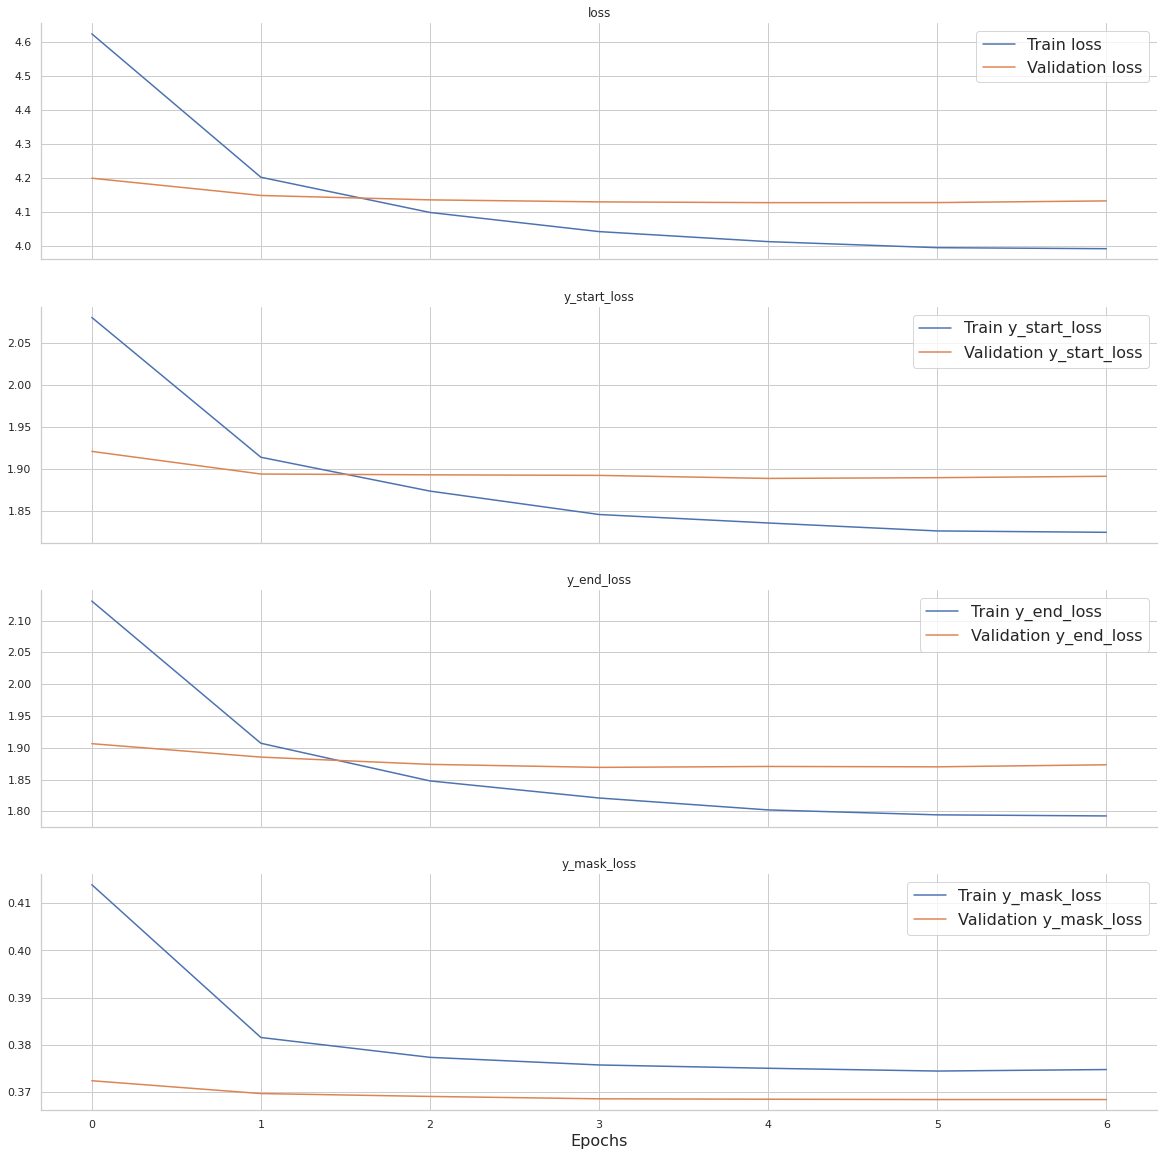

Fold: 3


IndexError: ignored

In [18]:
#@title
for n_fold in range(config['N_FOLDS']):
    print('Fold: %d' % (n_fold+1))
    plot_metrics(history_list[n_fold])

# Model evaluation

In [19]:
#@title
display(evaluate_model_kfold(k_fold, config['N_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric/Jaccard,,,,,,,,,,,,,
Overall,0.763933,0.724515,0.039417,0.762003,0.723136,0.761876,0.721838,0.755339,0.719632,0.768733,0.727483,0.771712,0.730487
Sentiment negative,0.620071,0.550787,0.069284,0.618006,0.542915,0.617493,0.545157,0.600783,0.558624,0.632841,0.549483,0.631234,0.557756
Sentiment neutral,0.977755,0.975985,0.001769,0.978234,0.975097,0.977203,0.976799,0.977822,0.975632,0.978177,0.976199,0.977338,0.976200
Sentiment positive,0.607550,0.544700,0.062851,0.602536,0.548450,0.603968,0.539929,0.597014,0.522283,0.610993,0.555288,0.623241,0.557548
0 <= text tokens < 3,0.955583,0.953652,0.001931,0.955556,0.943548,0.964912,0.940678,0.946121,0.981818,0.951754,0.940678,0.959574,0.961538
3 <= text tokens < 15,0.811157,0.783671,0.027486,0.808573,0.786698,0.808391,0.786576,0.804513,0.776433,0.815983,0.782599,0.818326,0.786050
15 <= text tokens < 30,0.735722,0.687719,0.048002,0.733371,0.687968,0.733343,0.676527,0.727957,0.679874,0.741716,0.688945,0.742221,0.705283
30 <= text tokens < 45,0.705874,0.656633,0.049241,0.707293,0.638795,0.707198,0.656295,0.689988,0.664570,0.707028,0.679413,0.717864,0.644090
45 <= text tokens < 120,0.826788,0.778020,0.048769,0.793438,0.844124,0.824224,0.790317,0.850469,0.642007,0.823018,0.797411,0.842792,0.816239


# Visualize predictions

In [20]:
#@title
k_fold['jaccard_mean'] = 0

for n in range(config['N_FOLDS']):
    k_fold['jaccard_mean'] += k_fold[f'jaccard_fold_{n+1}'] / config['N_FOLDS']

display(k_fold[['text', 'selected_text', 'sentiment', 'text_tokenCnt', 
                'selected_text_tokenCnt', 'jaccard', 'jaccard_mean'] + [c for c in k_fold.columns if (c.startswith('prediction_fold'))]].head(15))

,text,selected_text,sentiment,text_tokenCnt,selected_text_tokenCnt,jaccard,jaccard_mean,prediction_fold_4,prediction_fold_5,prediction_fold_1,prediction_fold_2,prediction_fold_3
0,"i`d have responded, if i were going","i`d have responded, if i were going",neutral,10,10,1.000000,1.000000,"i`d have responded, if i were going","i`d have responded, if i were going","i`d have responded, if i were going","i`d have responded, if i were going","i`d have responded, if i were going"
1,sooo sad i will miss you here in san diego!!!,sooo sad,negative,13,3,0.200000,0.900000,sooo sad,sooo sad,sooo sad,sooo sad,sad
2,my boss is bullying me...,bullying me,negative,6,2,0.166667,0.333333,bullying me...,bullying me...,bullying me...,bullying me...,bullying me...
3,what interview! leave me alone,leave me alone,negative,6,3,0.600000,1.000000,leave me alone,leave me alone,leave me alone,leave me alone,leave me alone
4,"sons of ****, why couldn`t they put them on the releases we already bought","sons of ****,",negative,17,4,0.214286,1.000000,"sons of ****,","sons of ****,","sons of ****,","sons of ****,","sons of ****,"
5,http://www.dothebouncy.com/smf - some shameless plugging for the best rangers forum on earth,http://www.dothebouncy.com/smf - some shameless plugging for the best rangers forum on earth,neutral,27,27,1.000000,0.966667,http://www.dothebouncy.com/smf - some shameless plugging for the best rangers forum on earth,http://www.dothebouncy.com/smf - some shameless plugging for the best rangers forum on earth,some shameless plugging for the best rangers forum on earth,http://www.dothebouncy.com/smf - some shameless plugging for the best rangers forum on earth,http://www.dothebouncy.com/smf - some shameless plugging for the best rangers forum on earth
6,2am feedings for the baby are fun when he is all smiles and coos,fun,positive,17,1,0.071429,1.000000,fun,fun,fun,fun,fun
7,soooo high,soooo high,neutral,3,3,1.000000,1.000000,soooo high,soooo high,soooo high,soooo high,soooo high
8,both of you,both of you,neutral,3,3,1.000000,1.000000,both of you,both of you,both of you,both of you,both of you
9,journey!? wow... u just became cooler. hehe... (is that possible!?),wow... u just became cooler.,positive,19,7,0.500000,0.680000,wow...,wow... u just became cooler.,wow... u just became cooler.,wow... u just became cooler.,wow...
